reference
- https://github.com/huggingface/transformers/blob/master/src/transformers/modeling_albert.py
- https://github.com/google-research/ALBERT/blob/master/modeling.py

In [1]:
from functools import reduce

In [2]:
def get_num_params(model):
    n_params = 0
    for param in model.parameters():
        param_shape = list(param.shape)
        n_params += reduce(lambda x, y: x*y, param_shape)
    return n_params

#### input/output embedding

In [3]:
from transformers import AlbertModel, AlbertTokenizer
import torch

model_nm = 'albert-large-v1'
tokenizer = AlbertTokenizer.from_pretrained(model_nm)
model = AlbertModel.from_pretrained(model_nm)
input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
outputs = model(input_ids)
last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple

I0202 13:31:17.068492 139694552987392 file_utils.py:38] PyTorch version 1.1.0 available.
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
I0202 13:31:19.300231 139694552987392 tokenization_utils.py:418] loading file https://s3.amazonaws.com/models.huggingface.co/bert/albert-large-spiece.model from cache at /root/.cache/torch/transformers/66f081790a7cd178fa9a63002d945aaed2d289c5fc14cb2fb1db322009485aaf.c81d4deb77aec08ce575b7a39a989a79dd54f321bfb82c2b54dd35f52f8182cf
I0202 13:31:20.189369 139694552987392 configuration_utils.py:233] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/albert-large-config.json from cache at /root/.cache/torch/transformers/a82c2c506ba12688420ce135fa48c03861b977b25b51839a5ad8942cb5f

In [4]:
last_hidden_states.shape

torch.Size([1, 8, 1024])

In [5]:
emb_output = model.embeddings(input_ids)
emb_output.shape

torch.Size([1, 8, 128])

In [6]:
attention_mask = torch.ones(input_ids.shape)
extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
extended_attention_mask = extended_attention_mask.to(dtype=torch.float32)  # fp16 compatibility
extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

In [7]:
n_layers = model.encoder.config.num_hidden_layers
n_layers

24

In [8]:
head_mask = [None] * n_layers

In [9]:
trans = model.encoder(emb_output, extended_attention_mask, head_mask)

In [10]:
trans[0].shape, trans[0].sum()

(torch.Size([1, 8, 1024]), tensor(-154.9911, grad_fn=<SumBackward0>))

In [11]:
hidden_states = model.encoder.embedding_hidden_mapping_in(emb_output)
dist = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
distance_list = []
for i in range(n_layers):
    input_embedding = hidden_states#.view(-1, 8*768)
    layer_out = model.encoder.albert_layer_groups[0](
        hidden_states,
        extended_attention_mask,
        head_mask[0*n_layers:(0+1)*n_layers]
    )
    hidden_states = layer_out[0]
    output_embedding = hidden_states#.view(-1, 8*768)
    
    distance = torch.dist(input_embedding, output_embedding, p=2)
    print(i, hidden_states.shape, input_embedding.shape, output_embedding.shape, distance)
    distance_list.append(distance)

0 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(39.1129, grad_fn=<DistBackward>)
1 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(20.0344, grad_fn=<DistBackward>)
2 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(16.1824, grad_fn=<DistBackward>)
3 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(12.3042, grad_fn=<DistBackward>)
4 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(9.8303, grad_fn=<DistBackward>)
5 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(7.6768, grad_fn=<DistBackward>)
6 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(6.3892, grad_fn=<DistBackward>)
7 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(5.5773, grad_fn=<DistBackward>)
8 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Size([1, 8

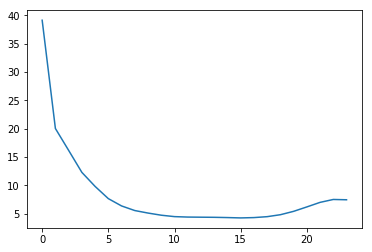

In [14]:
import matplotlib.pyplot as plt
plt.plot(distance_list)
plt.show()

In [16]:
get_num_params(model)

17683968

#### can ALBERT do NSP?

In [1]:
import sys
sys.path.insert(0, '/anything/git/ALBERT/')

In [2]:
import tensorflow_hub as hub
import tensorflow as tf

import tensorflow as tf
import modeling
import numpy as np
import random
import modeling

from tokenization import FullTokenizer
from load_dataset import create_training_instances

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
model_nm = 'albert_large'
model_nm = 'albert_xxlarge'

In [4]:
vocab_file = '/anything/git/ALBERT/models/{}/30k-clean.vocab'.format(model_nm)
tokenizer = FullTokenizer(vocab_file=vocab_file)

spm_file = '/anything/git/ALBERT/models/{}/30k-clean.model'.format(model_nm)
tokenizer = FullTokenizer(vocab_file=None, spm_model_file=spm_file)

In [5]:
config = modeling.AlbertConfig.from_json_file('/anything/git/ALBERT/models/{}/albert_config.json'.format(model_nm))

In [6]:
max_seq_length = config.max_position_embeddings
dupe_factor = 40
short_seq_prob = 0.1
masked_lm_prob = 0.15
max_predictions_per_seq = 20
rng = random.Random(100)

In [7]:
# SOP label should be 0
sent_1 = 'How old are you?'
sent_2 = 'I am 35 years old'

# SOP label should be 1
sent_1 = 'How old are you?'
sent_2 = 'The Eiffel Tower is in Paris'

# SOP label should be 0
# sent_1 = 'is Obama the president of the US?'
# sent_2 = 'No but he was'

In [8]:
# right order
tokens_1 = tokenizer.tokenize(sent_1)
tokens_2 = tokenizer.tokenize(sent_2)
tokens = ['[CLS]'] + tokens_1 + ['[SEP]'] + tokens_2 + ['[SEP]']
input_ids = tokenizer.convert_tokens_to_ids(tokens)
segment_ids = [0] * (len(tokens_1) + 2) + [1] * (len(tokens_2) + 1)
token_type_ids = [1] * len(segment_ids)
label = 0

In [9]:
# reverse order
tokens_1 = tokenizer.tokenize(sent_1)
tokens_2 = tokenizer.tokenize(sent_2)
tokens = ['[CLS]'] + tokens_2 + ['[SEP]'] + tokens_1 + ['[SEP]']
input_ids = tokenizer.convert_tokens_to_ids(tokens)
segment_ids = [0] * (len(tokens_2) + 2) + [1] * (len(tokens_1) + 1)
token_type_ids = [1] * len(segment_ids)
label = 1

In [9]:
print(input_ids)
print(segment_ids)
print(token_type_ids)
print(label)

[2, 13, 1, 3581, 315, 50, 42, 60, 3, 13, 1, 438, 13, 1, 6021, 532, 13, 1, 3581, 106, 25, 19, 13, 1, 14688, 3]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0


In [10]:
# Already been converted from strings into ids
input_ids = tf.constant([input_ids])
segment_ids = tf.constant([segment_ids])
token_type_ids = tf.constant([token_type_ids])
input_label = tf.constant([label])

In [11]:
model = modeling.AlbertModel(config=config, is_training=False,
  input_ids=input_ids, input_mask=token_type_ids, token_type_ids=token_type_ids)

(1, 64, 26, 64) (1, 64, 26, 64)
(1, 64, 26, 64) (1, 64, 26, 64)
(1, 64, 26, 64) (1, 64, 26, 64)
(1, 64, 26, 64) (1, 64, 26, 64)
(1, 64, 26, 64) (1, 64, 26, 64)
(1, 64, 26, 64) (1, 64, 26, 64)
(1, 64, 26, 64) (1, 64, 26, 64)
(1, 64, 26, 64) (1, 64, 26, 64)


W0202 13:35:22.587784 139701824845568 deprecation.py:323] From /anything/git/ALBERT/modeling.py:253: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.Dense instead.
W0202 13:35:22.589021 139701824845568 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow_core/python/layers/core.py:187: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


(1, 64, 26, 64) (1, 64, 26, 64)
(1, 64, 26, 64) (1, 64, 26, 64)
(1, 64, 26, 64) (1, 64, 26, 64)
(1, 64, 26, 64) (1, 64, 26, 64)


In [12]:
def get_sentence_order_output(albert_config, input_tensor, labels):
    with tf.variable_scope("cls/seq_relationship"):
        output_weights = tf.get_variable(
            "output_weights",
            shape=[2, albert_config.hidden_size],
            initializer=modeling.create_initializer(
                albert_config.initializer_range))
        output_bias = tf.get_variable(
            "output_bias", shape=[2], initializer=tf.zeros_initializer())
        logits = tf.matmul(input_tensor, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        log_probs = tf.nn.log_softmax(logits, axis=-1)
        labels = tf.reshape(labels, [-1])
        one_hot_labels = tf.one_hot(labels, depth=2, dtype=tf.float32)
        per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        loss = tf.reduce_mean(per_example_loss)
        return (loss, per_example_loss, log_probs, output_weights)

In [13]:
(sentence_order_loss, sentence_order_example_loss, sentence_order_log_probs, out_weight) = get_sentence_order_output(config, model.get_pooled_output(), input_label)

In [14]:
# Class used to save and/or restore Tensor Variables
saver = tf.train.Saver()

In [15]:
with tf.Session() as sess:
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
    saver.restore(sess, '/anything/git/ALBERT/models/{}/model.ckpt-best'.format(model_nm))
    
    sop_loss, sop_prob, ow = sess.run([sentence_order_loss, sentence_order_log_probs, out_weight])
    pred = 0 if sop_prob[0][0] > sop_prob[0][1] else 1
    print(sop_loss, sop_prob.shape, sop_prob, np.exp(sop_prob))
    print(pred, label)

0.30321643 (1, 2) [[-0.30321643 -1.3410888 ]] [[0.73843926 0.26156074]]
0 0
